In [ ]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Bioinformatic/ML_NN/project_bird/avians"
RESCALE_SIZE = 299, 299
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")

Using device: cuda


## Напишем класс `AvianDataset`

In [ ]:
class AviansDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        transforms.RandomHorizontalFlip(),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

## Класс для тренировки и валидации модели

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = Tensor(self.model(inputs))
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out.keys(), targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

Получем список всех файлов. Создаем для каждого метку класса и делим на тренировку и валидацию.

In [ ]:
train_val_files = sorted(list(Path(DATA_PATH).rglob("*.jpg")))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
N_CLASSES = len(set(train_val_labels))
N_CLASSES

20

In [ ]:
train_val_files[0].parent.name

'ABBOTTS BABBLER'

Важно посмотреть на распределение классов. Если оно у нас будет несбалансированным, то может быть, хорошей идеей поработать с этим (например, тот же upsampling редко представленных классов):

In [ ]:
from collections import Counter
avian = dict(Counter(train_val_labels))

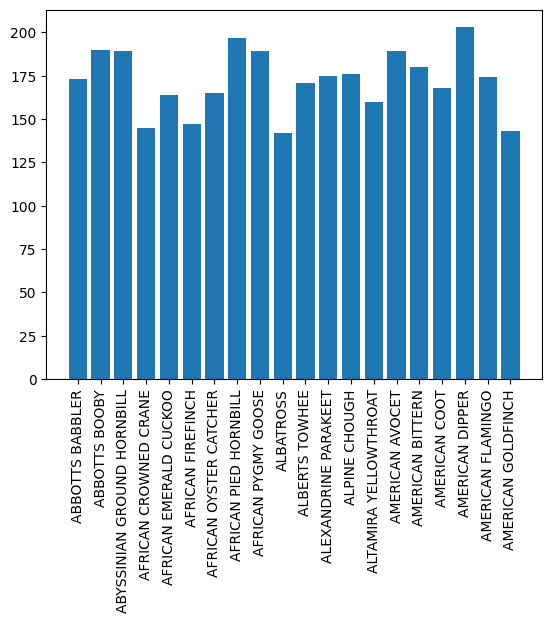

In [ ]:
plt.bar(range(len(avian)), list(avian.values()), align='center')
plt.xticks(range(len(avian)), list(avian.keys()), rotation = 90);

Создаем датасеты и даталоадеры.

In [ ]:
trainset = AviansDataset(train_files)
valset = AviansDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print(trainloader) 

Возьмем какую-то готовую модель, например, `VGG19` с батч-нормализацией:

In [ ]:
model = torchvision.models.mnasnet0_75(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet0_75_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_75_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mnasnet0_75-7090bc5f.pth" to /root/.cache/torch/hub/checkpoints/mnasnet0_75-7090bc5f.pth
100%|██████████| 12.3M/12.3M [00:00<00:00, 33.9MB/s]


In [ ]:
model

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [ ]:
num_features = 1280
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(num_features, N_CLASSES))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

### Погнали учится

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 81 out of 81
Validation: batch 27 out of 27

Epoch 1 out of 10: Train loss = 1.7103802613270136, validation loss = 0.669313760543311 
                                         Train metric = 0.5875968992248062, validation metric = 0.23255813953488372

Training: batch 81 out of 81
Validation: batch 27 out of 27

Epoch 2 out of 10: Train loss = 0.40980999052156636, validation loss = 0.6106326284783857 
                                         Train metric = 0.7546511627906977, validation metric = 0.23953488372093024

Training: batch 81 out of 81
Validation: batch 27 out of 27

Epoch 3 out of 10: Train loss = 0.21871597945322224, validation loss = 0.45555023573063036 
                                         Train metric = 0.7984496124031008, validation metric = 0.2441860465116279

Training: batch 81 out of 81
Validation: batch 27 out of 27

Epoch 4 out of 10: Train loss = 0.18021887635099298, validation loss = 0.4215597532413624 
                                         Tr

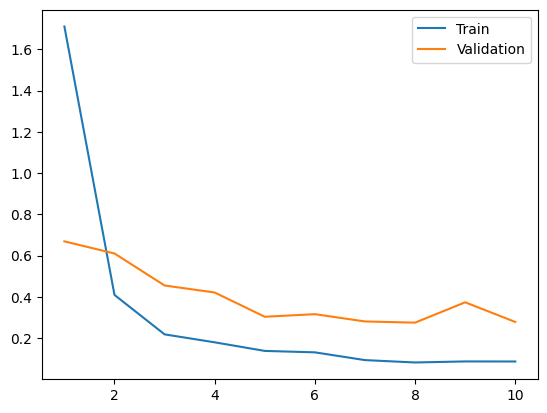

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model, valloader)

0.9325581395348838

In [ ]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [ ]:
calculate_metric(model, valloader, f1_macro)

0.9331165115137414

In [ ]:
calculate_metric(model, valloader, f1_micro)

0.9325581395348838

#### Предсказания

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp.reshape(*RESCALE_SIZE), cmap="gray")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [ ]:
label_encoder = trainset.label_encoder

In [ ]:
predict(model, )

Вывод картинки

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

random_characters = int(np.random.uniform(0, 500))
im_val, label = valset[random_characters]

label

9

In [ ]:
valset.label_encoder.inverse_transform([label])[0]

'ALBATROSS'

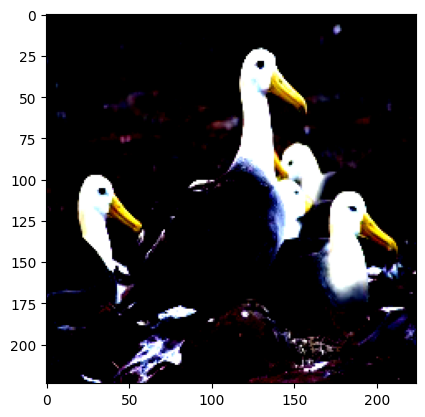

In [ ]:
plt.imshow(im_val.permute(1,2,0))

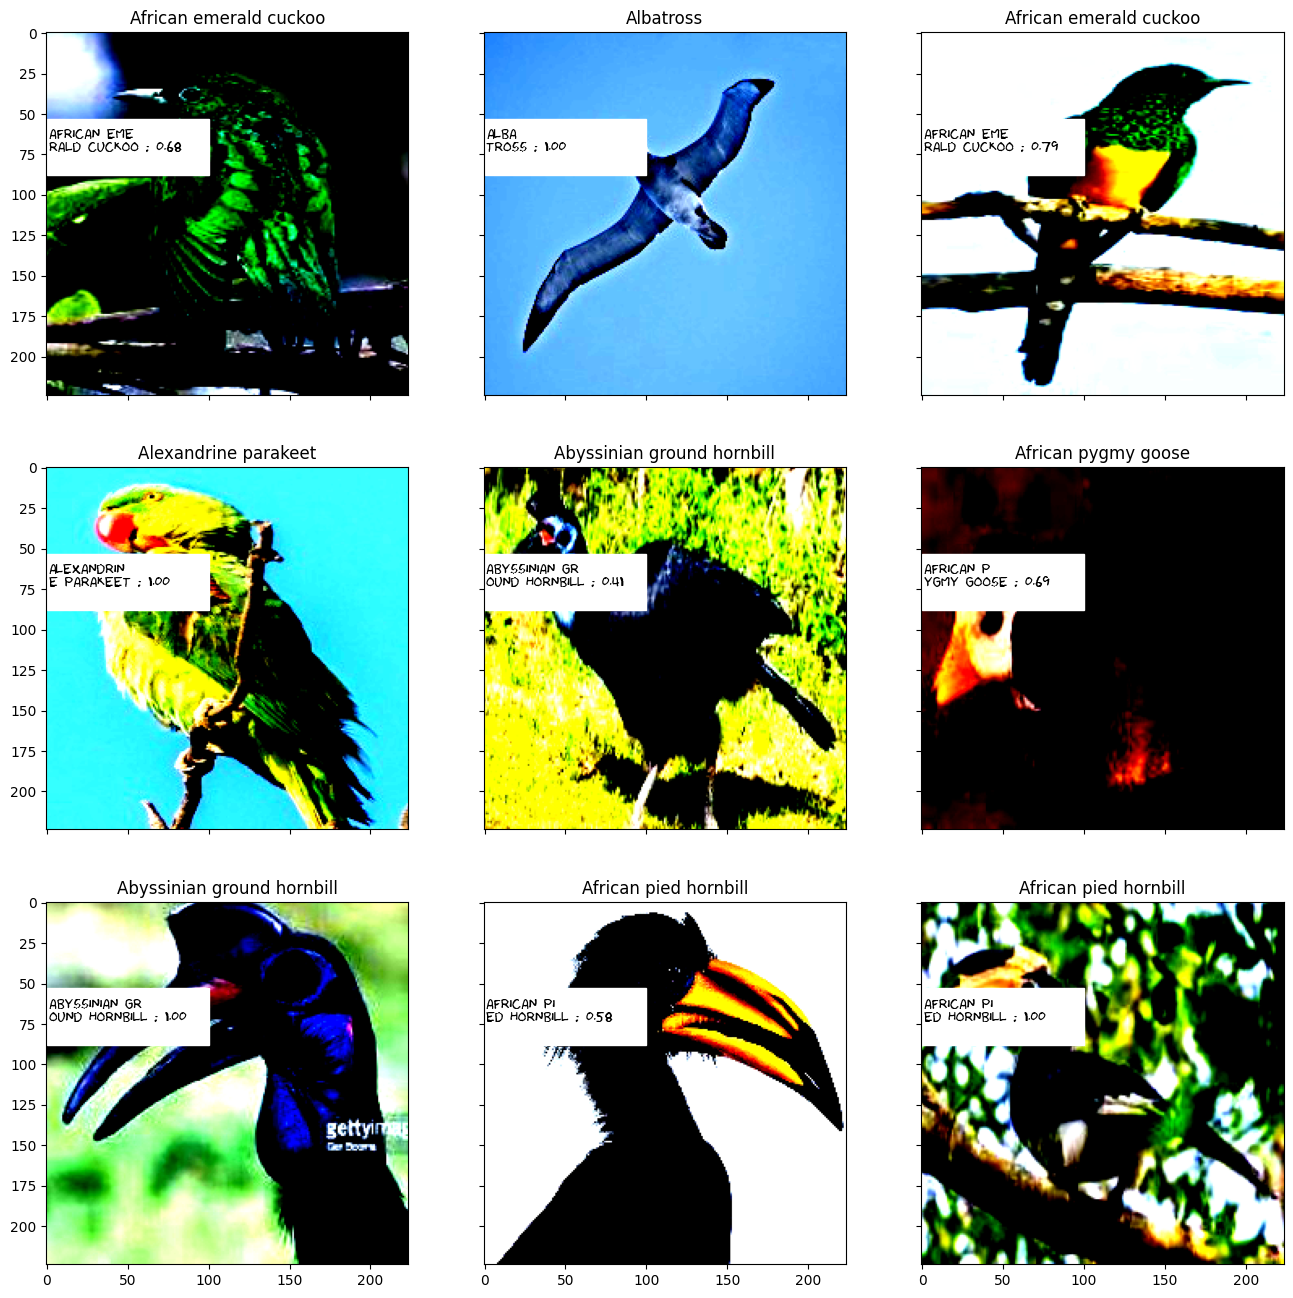

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 500))
    im_val, label = valset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valset.label_encoder.inverse_transform([label])[0].split("_")))
    
    

    fig_x.imshow(im_val.permute(1,2,0))
    fig_x.title.set_text(img_label)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 100, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + "\n" + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.2f}".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment="left", fontproperties=font,
                    verticalalignment="top", fontsize=10, color="black", fontweight="bold")

In [ ]:
val_images = [valset[id][0].unsqueeze(0) for id in range(len(valset))]
val_predictions = get_predicts(model, val_images)

In [ ]:
val_predictions

array([[3.3034157e-04, 7.8112030e-01, 7.9238211e-04, ..., 4.7346464e-04,
        1.4303655e-02, 2.2074455e-04],
       [8.2002101e-05, 2.5276357e-04, 9.9912792e-01, ..., 3.6607828e-06,
        2.6266398e-05, 1.7275624e-05],
       [5.6497488e-06, 1.7249347e-05, 9.9950898e-01, ..., 5.5974505e-07,
        5.8769942e-06, 1.1165766e-06],
       ...,
       [2.1607842e-04, 5.5437937e-04, 1.1793033e-03, ..., 5.9003076e-05,
        9.6354663e-01, 1.5874353e-04],
       [2.9681728e-04, 2.5373469e-03, 8.9549198e-04, ..., 3.8582570e-04,
        1.0940781e-03, 9.6741283e-01],
       [2.0616723e-03, 3.2532368e-02, 8.7576173e-03, ..., 2.2645523e-03,
        5.1003820e-03, 7.9835576e-01]], dtype=float32)

In [ ]:
y_pred_val = np.argmax(val_predictions, -1)
actual_labels = [valset[id][1] for id in range(len(valset))]
preds_class = [label_encoder.classes_[i] for i in y_pred_val]

val_mertics_report = pd.DataFrame(classification_report(actual_labels, y_pred_val, output_dict=True)).T
val_mertics_report.index = list(label_encoder.inverse_transform(np.arange(20))) + ["accuracy", "macro avg", "weighted avg"]

In [ ]:
val_mertics_report

,precision,recall,f1-score,support
ABBOTTS BABBLER,0.800000,0.837209,0.818182,43.000000
ABBOTTS BOOBY,0.836735,0.854167,0.845361,48.000000
ABYSSINIAN GROUND HORNBILL,0.954545,0.893617,0.923077,47.000000
AFRICAN CROWNED CRANE,0.947368,1.000000,0.972973,36.000000
AFRICAN EMERALD CUCKOO,0.971429,0.829268,0.894737,41.000000
AFRICAN FIREFINCH,1.000000,0.918919,0.957746,37.000000
AFRICAN OYSTER CATCHER,0.976190,1.000000,0.987952,41.000000
AFRICAN PIED HORNBILL,0.937500,0.918367,0.927835,49.000000
AFRICAN PYGMY GOOSE,1.000000,0.957447,0.978261,47.000000
ALBATROSS,0.853659,0.972222,0.909091,36.000000


### Проверка на соответствие размера

In [ ]:
for i in tqdm(trainset):
    if i[0].shape != torch.Size([3, 224, 224]):
        print(i[0].shape)

In [ ]:
model_mnasnet = torchvision.models.mnasnet1_3(pretrained=True)
model_mnasnet


CoCa

In [ ]:
! pip install CoCa-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00


In [ ]:

model_deep = torchvision.models.inception_v3(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 72.1MB/s] 


In [ ]:
model_deep

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model_deep.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
num_features = 1024
model_deep.fc = nn.Linear(in_features=2048, out_features=20, bias=True)


model_deep = model_deep.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deep.parameters(), lr=3e-4)

In [ ]:
torch.cuda.empty_cache()

### Погнали учится

In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=fac3b54cff5e966bcb0f6df42c44ad780d5681ac65eb323a4832c95430715f22
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |


In [ ]:
trainer = Trainer(model_deep, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

ValueError: ignored

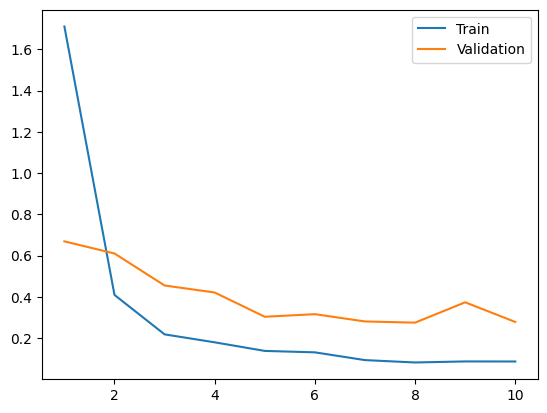

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model_deep, valloader)

0.9325581395348838

In [ ]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [ ]:
calculate_metric(model_deep, valloader, f1_macro)

0.9331165115137414

In [ ]:
calculate_metric(model_deep, valloader, f1_micro)

0.9325581395348838

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = torch.Tensor(self.model(inputs))
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out.keys(), targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()